In [56]:
# This is distributed under BSD 3-Clause license

import torch
import numpy
import os
import errno

from torch import optim
from torch import legacy
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


from six.moves import urllib

#loss_plot = []

def tensor_from_file(root, filename,
                     base_url = 'https://documents.epfl.ch/users/f/fl/fleuret/www/data/bci'):

    file_path = os.path.join(root, filename)

    if not os.path.exists(file_path):
        try:
            os.makedirs(root)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        url = base_url + '/' + filename

        print('Downloading ' + url)
        data = urllib.request.urlopen(url)
        with open(file_path, 'wb') as f:
            f.write(data.read())

    return torch.from_numpy(numpy.loadtxt(file_path))

def load(root, train = True, download = True, one_khz = False):
    """
    Args:

        root (string): Root directory of dataset.

        train (bool, optional): If True, creates dataset from training data.

        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

        one_khz (bool, optional): If True, creates dataset from the 1000Hz data instead
            of the default 100Hz.

    """

    nb_electrodes = 28

    if train:

        if one_khz:
            dataset = tensor_from_file(root, 'sp1s_aa_train_1000Hz.txt')
        else:
            dataset = tensor_from_file(root, 'sp1s_aa_train.txt')

        input = dataset.narrow(1, 1, dataset.size(1) - 1)
        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = dataset.narrow(1, 0, 1).clone().view(-1).long() #changer le type suivant le loss criterion

    else:

        if one_khz:
            input = tensor_from_file(root, 'sp1s_aa_test_1000Hz.txt')
        else:
            input = tensor_from_file(root, 'sp1s_aa_test.txt')
        target = tensor_from_file(root, 'labels_data_set_iv.txt')

        input = input.float().view(input.size(0), nb_electrodes, -1)
        target = target.view(-1).long() #changer le type suivant le loss criterion

    return input, target
            
#################################################################

def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0
    model.eval()
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors
            

# Loading data, Increase the Dataset and Create Validation Set


torch.Size([270, 28, 50])
torch.Size([270])
torch.Size([30, 28, 50])
torch.Size([30])
torch.Size([810, 28, 50])
torch.Size([810])
torch.Size([30, 28, 50])
torch.Size([30])


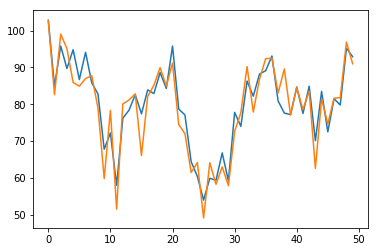

In [77]:
train_input, train_target = load("data",True, False)
test_input, test_target = load("data",False, False)
train_input, train_target, test_input, test_target = \
Variable(train_input.narrow(0, 0,300)), Variable(train_target.narrow(0,0,300)), Variable(test_input), Variable(test_target)

def valSet(train_input, train_target,percentageVal):
    
    permutation = torch.randperm(train_input.size()[0])
    sizeVal=round(percentageVal/100*train_input.size()[0])
    
    validation_set_input=train_input[permutation].narrow(0,0,sizeVal)
    validation_set_target=train_target[permutation].narrow(0,0,sizeVal)
    new_train_input=train_input[permutation].narrow(0,sizeVal,train_input.size()[0]-sizeVal)
    new_train_target=train_target[permutation].narrow(0,sizeVal,train_input.size()[0]-sizeVal)
    
    return new_train_input, new_train_target, validation_set_input, validation_set_target

train_input, train_target, validation_set_input, validation_set_target = valSet(train_input, train_target, 10)


print(train_input.size())
print(train_target.size())
print(validation_set_input.size())
print(validation_set_target.size())

#adding white noise to the signal
dataNoisy=Variable(torch.Tensor(train_input.size()))
for i in range(0,train_input.size(0)):
    for j in range(0,train_input.size(1)):
        noise = numpy.random.normal(0,5,50) #vector of 50 values with normal distribution of mean=0, std=2
        #noise = numpy.random.uniform(-2,2, 50)
        noiseVar=Variable(torch.Tensor(noise))
        dataNoisy[i,j,:]=train_input[i,j,:].add(noiseVar)



#adding white noise to the signal
dataNoisy2=Variable(torch.Tensor(train_input.size()))
for i in range(0,train_input.size(0)):
    for j in range(0,train_input.size(1)):
        noise = numpy.random.normal(0,3,50) #vector of 50 values with normal distribution of mean=0, std=4
        #noise = numpy.random.uniform(-4,4,50)
        noiseVar=Variable(torch.Tensor(noise))
        dataNoisy2[i,j,:]=train_input[i,j,:].add(noiseVar)




#verification
plt.plot(train_input[30,10,:].data.numpy())
plt.plot(dataNoisy[30,10,:].data.numpy())

train_input = torch.cat((train_input, dataNoisy), 0) #the two matrices are concatenated
train_input = torch.cat((train_input, dataNoisy2), 0)

new_train_target=torch.cat((train_target, train_target), 0)
train_target=torch.cat((new_train_target, train_target), 0)


print(train_input.size())
print(train_target.size())
print(validation_set_input.size())
print(validation_set_target.size())

# Train Model function

In [78]:
def train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size, lr):
    step_size = 20
    model.train()
    
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    #Optimizer to update the Learning rate
    scheduler = 0
# Activate one of the two step optimizer if you want to have one

    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, threshold=1, factor=0.5, patience = 30 )
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=0.1, last_epoch=-1)
   
    
    for e in range(0, nb_epochs):
        permutation = torch.randperm(train_input.size()[0])
        sum_loss = 0
        for b in range(0, train_input.size(0), batch_size):
            indices = permutation[b:b+batch_size]
            batch_input, batch_target = train_input[indices], train_target[indices]
            
            output = model(batch_input)
            loss = criterion(output, batch_target)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss
            
        #print("The loss is :"+str(loss)+" for epoch :"+str(e))
        loss_plot.append(sum_loss.data.numpy())
        #print(str(int((e/nb_epochs)*100))+"%")
        if sum_loss.data.numpy()< 0.01:
            break
        if scheduler != 0:

            #scheduler.step(sum_loss.data.numpy())
            scheduler.step()
            
    return e

# Network Model

In [79]:
#################################################################

#lr 1e-5 100 epochs
class Net_lin_dropout(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_lin_dropout, self).__init__()
        self.fc1 = nn.Linear(28*50,1000)
        self.fc2 = nn.Linear(1000, 400)
        self.fc3 = nn.Linear(400, 20)
        self.fc4 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        nn.Dropout()
        x = F.relu(self.fc3(x))
        nn.Dropout()
        x = self.fc4(x)
        return x

####################################################################################################################


class Net_basic(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_basic, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=2)
        self.fc1 = nn.Linear(128*3, nb_hidden*3)
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden*2)
        self.fc3 = nn.Linear(nb_hidden*2, nb_hidden)
        self.fc4 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#model = nn.Sequential(
    #nn.Conv1d(28, 32, kernel_size=5), 
    #nn.ReLU(),
    #nn.Conv1d(56, 56, kernel_size=4, stride = 2),
    #nn.ReLU(),
    #nn.MaxPool1d(kernel_size = 5, stride = 3),
    #nn.ReLU(),
    #nn.Conv1d(56,56, kernel_size = 4, stride = 1),
    #nn.ReLU(),
    #nn.Linear(32*46,79),
    #nn.ReLU(),
    #nn.Linear(79, 2))




In [80]:
#method seen on https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(1,6))
        self.conv2 =  nn.Conv2d(28, 1, kernel_size=(1,1))
        self.conv3 = nn.Conv1d(20, 40, kernel_size=10)
        self.conv4 = nn.Conv1d(40, 80, kernel_size=4)
        self.conv5 = nn.Conv1d(80, 160, kernel_size=4)
        
        
        self.fc1 = nn.Linear(160*2, nb_hidden*3)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #Nx28*50
        #print(x.size())
        x=x.unsqueeze(1) #Nx1x28x50
        #print(x.size())
        x=F.elu(self.conv1(x),alpha=4.0, inplace = True ) #Nx20x28x45
        #print(x.size())
        x=x.transpose(1,2) #Nx28x20x45
        #print(x.size())
        x=F.elu(self.conv2(x)) #Nx1x20x45
        #print("efwef"+str(x.size()))
        
        
        x=x.squeeze() #Nx20x45
        #print(x.size())
        #time.sleep(10)
        x = F.relu(F.max_pool1d(x,4,stride = 1)) #Nx20x42
        
        
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=4,stride = 1 )) #Nx40x33 -> Nx40x30
        
        
        x = F.relu(F.max_pool1d(self.conv4(x), kernel_size=3,stride = 3 )) #Nx80x27 -> Nx80x9
        
        
        x = F.relu(F.max_pool1d(self.conv5(x), kernel_size=3,stride = 3 )) #Nx160x6 -> Nx160x2   
        
        
        
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [81]:
class NetSWAG(nn.Module):
    def __init__(self, nb_hidden):
        super(NetSWAG, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(128*11, nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [82]:
class NetDROP(nn.Module):
    def __init__(self, nb_hidden):
        super(NetDROP, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4)
        self.fc1 = nn.Linear(256*4, 3*nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x=self.dropout(x)
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x=self.dropout(x)
        x = F.relu(self.fc2(x))
        x=self.dropout(x)
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [83]:
class NetGIT(nn.Module):
    def __init__(self, nb_hidden):
        super(NetGIT, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=2)
        self.fc1 = nn.Linear(128*3, nb_hidden*3)
        self.fc2 = nn.Linear(nb_hidden*3, nb_hidden*2)
        self.fc3 = nn.Linear(nb_hidden*2, nb_hidden)
        self.fc4 = nn.Linear(nb_hidden, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [84]:
class Net_convnet(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_convnet, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*11, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)        

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = self.fc3(x)
        return x

In [85]:
class Net_convnet_dropout(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_convnet_dropout, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*11, nb_hidden)
        self.fc3 = nn.Linear(nb_hidden, 2)        

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        nn.Dropout()
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        nn.Dropout()
        x = self.fc3(x)
        return x

In [86]:
class NetOLDANDDUMB2(nn.Module):
    def __init__(self, nb_hidden):
        super(NetOLDANDDUMB2, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3)
        #self.conv3 = nn.Conv1d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(64*11, nb_hidden)
        
        self.fc2 = nn.Linear(nb_hidden, 30)
        self.fc3 = nn.Linear(30, 2)
        #self.dropout = nn.Dropout()
        

    def forward(self, x):
        nn.Dropout(p = 0.7)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        nn.Dropout(p = 0.7)
        x = F.relu(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        #x = F.relu(F.max_pool1d(self.conv3(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1,x.data.size()[1]* x.data.size()[2])))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

# Loading the right model

In [87]:
# Select you model here!!!
#||||||||||||||||||||||||
#VVVVVVVVVVVVVVVVVVVVVVVV

model = Netbasic(150)

# Testing function

train_error 0.00% validation_set_error 30.00% test_error 30.00%


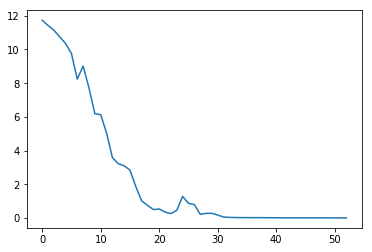

train_error AVG 0.00% validation_set_error AVG 30.00% test_error AVG 30.00%
train_error BEST 0.00% validation_set_error BEST 30.00% test_error BEST 30.00%



train_error 0.00% validation_set_error 26.67% test_error 32.00%


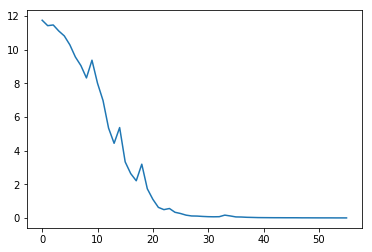

train_error AVG 0.00% validation_set_error AVG 28.33% test_error AVG 31.00%
train_error BEST 0.00% validation_set_error BEST 26.67% test_error BEST 30.00%



train_error 0.00% validation_set_error 30.00% test_error 31.00%


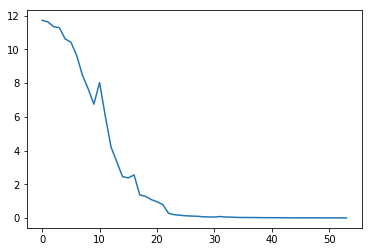

train_error AVG 0.00% validation_set_error AVG 28.89% test_error AVG 31.00%
train_error BEST 0.00% validation_set_error BEST 26.67% test_error BEST 30.00%



train_error 0.00% validation_set_error 23.33% test_error 31.00%


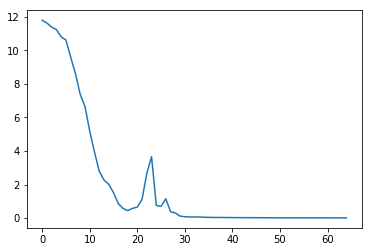

train_error AVG 0.00% validation_set_error AVG 27.50% test_error AVG 31.00%
train_error BEST 0.00% validation_set_error BEST 23.33% test_error BEST 30.00%



train_error 0.00% validation_set_error 26.67% test_error 32.00%


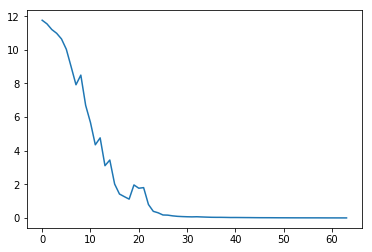

train_error AVG 0.00% validation_set_error AVG 27.33% test_error AVG 31.20%
train_error BEST 0.00% validation_set_error BEST 23.33% test_error BEST 30.00%



train_error 0.00% validation_set_error 33.33% test_error 31.00%


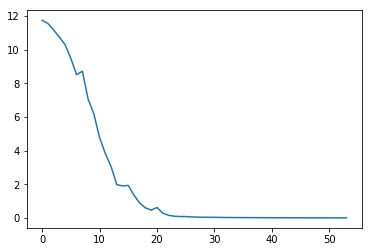

train_error AVG 0.00% validation_set_error AVG 28.33% test_error AVG 31.17%
train_error BEST 0.00% validation_set_error BEST 23.33% test_error BEST 30.00%



train_error 0.00% validation_set_error 26.67% test_error 33.00%


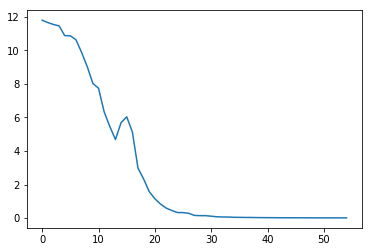

train_error AVG 0.00% validation_set_error AVG 28.10% test_error AVG 31.43%
train_error BEST 0.00% validation_set_error BEST 23.33% test_error BEST 30.00%



train_error 0.00% validation_set_error 30.00% test_error 29.00%


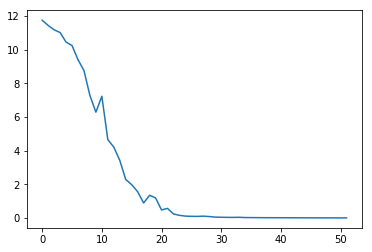

train_error AVG 0.00% validation_set_error AVG 28.33% test_error AVG 31.12%
train_error BEST 0.00% validation_set_error BEST 23.33% test_error BEST 29.00%





KeyboardInterrupt: 

In [88]:
# test multiple prior init

# Select you model here!!!
#||||||||||||||||||||||||
#VVVVVVVVVVVVVVVVVVVVVVVV

model = Net_lin_dropout(150)


nb_epochs =  100
batch_size = 50

lr = 1e-4


nb_training = 20

train_error = []
validation_error = []
test_error = []

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    epochs_reached = train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size, lr = lr)
    
    train_error.append(compute_nb_errors(model, train_input, train_target, 10) / train_input.size(0) * 100)
    validation_error.append(compute_nb_errors(model, validation_set_input, validation_set_target, 10) / validation_set_input.size(0) * 100)
    test_error.append(compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100)
  
    print('train_error {:.02f}% validation_set_error {:.02f}% test_error {:.02f}%'.format(train_error[i], validation_error[i], test_error[i]))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(epochs_reached+1),loss_plot)
    plt.show()
    print('train_error AVG {:.02f}% validation_set_error AVG {:.02f}% test_error AVG {:.02f}%'.format(
        numpy.asarray(train_error).mean(), 
        numpy.asarray(validation_error).mean(), 
        numpy.asarray(test_error).mean()))
    print('train_error BEST {:.02f}% validation_set_error BEST {:.02f}% test_error BEST {:.02f}%\n\n\n'.format(
        numpy.asarray(train_error).min(), 
        numpy.asarray(validation_error).min(), 
        numpy.asarray(test_error).min()))
    
    

In [ ]:
# test multiple prior init

# Select you model here!!!
#||||||||||||||||||||||||
#VVVVVVVVVVVVVVVVVVVVVVVV

model = Net_basic(150)


nb_epochs =  10
batch_size = 50

lr = 1e-4


nb_training = 20

train_error = []
validation_error = []
test_error = []

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    epochs_reached = train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size, lr = lr)
    
    train_error.append(compute_nb_errors(model, train_input, train_target, 10) / train_input.size(0) * 100)
    validation_error.append(compute_nb_errors(model, validation_set_input, validation_set_target, 10) / validation_set_input.size(0) * 100)
    test_error.append(compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100)
  
    print('train_error {:.02f}% validation_set_error {:.02f}% test_error {:.02f}%'.format(train_error[i], validation_error[i], test_error[i]))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(epochs_reached+1),loss_plot)
    plt.show()
    print('train_error AVG {:.02f}% validation_set_error AVG {:.02f}% test_error AVG {:.02f}%'.format(
        numpy.asarray(train_error).mean(), 
        numpy.asarray(validation_error).mean(), 
        numpy.asarray(test_error).mean()))
    print('train_error BEST {:.02f}% validation_set_error BEST {:.02f}% test_error BEST {:.02f}%\n\n\n'.format(
        numpy.asarray(train_error).min(), 
        numpy.asarray(validation_error).min(), 
        numpy.asarray(test_error).min()))
    
    

In [53]:
# test multiple prior init

# Select you model here!!!
#||||||||||||||||||||||||
#VVVVVVVVVVVVVVVVVVVVVVVV

model = Net_convnet(150)


nb_epochs =  10
batch_size = 50

lr = 1e-4


nb_training = 20

train_error = []
validation_error = []
test_error = []

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    epochs_reached = train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size, lr = lr)
    
    train_error.append(compute_nb_errors(model, train_input, train_target, 10) / train_input.size(0) * 100)
    validation_error.append(compute_nb_errors(model, validation_set_input, validation_set_target, 10) / validation_set_input.size(0) * 100)
    test_error.append(compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100)
  
    print('train_error {:.02f}% validation_set_error {:.02f}% test_error {:.02f}%'.format(train_error[i], validation_error[i], test_error[i]))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(epochs_reached+1),loss_plot)
    plt.show()
    print('train_error AVG {:.02f}% validation_set_error AVG {:.02f}% test_error AVG {:.02f}%'.format(
        numpy.asarray(train_error).mean(), 
        numpy.asarray(validation_error).mean(), 
        numpy.asarray(test_error).mean()))
    print('train_error BEST {:.02f}% validation_set_error BEST {:.02f}% test_error BEST {:.02f}%\n\n\n'.format(
        numpy.asarray(train_error).min(), 
        numpy.asarray(validation_error).min(), 
        numpy.asarray(test_error).min()))
    
    

NameError: name 'Net_covnet' is not defined

In [ ]:
# test multiple prior init

# Select you model here!!!
#||||||||||||||||||||||||
#VVVVVVVVVVVVVVVVVVVVVVVV

model = Net_convnet_dropout(150)


nb_epochs =  10
batch_size = 50

lr = 1e-4


nb_training = 20

train_error = []
validation_error = []
test_error = []

for i in range(0,nb_training):
    for p in model.parameters(): p.data.normal_(0, 0.01)
    loss_plot = []
    epochs_reached = train_model(model, train_input, train_target, loss_plot, nb_epochs, batch_size = batch_size, lr = lr)
    
    train_error.append(compute_nb_errors(model, train_input, train_target, 10) / train_input.size(0) * 100)
    validation_error.append(compute_nb_errors(model, validation_set_input, validation_set_target, 10) / validation_set_input.size(0) * 100)
    test_error.append(compute_nb_errors(model, test_input, test_target, 50) / test_input.size(0) * 100)
  
    print('train_error {:.02f}% validation_set_error {:.02f}% test_error {:.02f}%'.format(train_error[i], validation_error[i], test_error[i]))
    #loss_plot
    for p in model.parameters(): p.data.normal_(0, 0.01)
    plt.plot(range(epochs_reached+1),loss_plot)
    plt.show()
    print('train_error AVG {:.02f}% validation_set_error AVG {:.02f}% test_error AVG {:.02f}%'.format(
        numpy.asarray(train_error).mean(), 
        numpy.asarray(validation_error).mean(), 
        numpy.asarray(test_error).mean()))
    print('train_error BEST {:.02f}% validation_set_error BEST {:.02f}% test_error BEST {:.02f}%\n\n\n'.format(
        numpy.asarray(train_error).min(), 
        numpy.asarray(validation_error).min(), 
        numpy.asarray(test_error).min()))